# <center><u><font color="#110896"> Analyse de chats d'un groupe de Hackers pour en extraire le plus d'informations possible.</font></u></center>

### <font color="#110896"> Pour commencer notre analyse, nous allons d'abord importer les bibliothèques que nous utiliserons dans ce projet.

In [7]:
#! pip install textblob

In [17]:
# importer des bibliothèques de base
import os
import re
import spacy
import string
import numpy as np
import pandas as pd
from collections import Counter

# pour la visualisation
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# NLP tools
import nltk

# Mots communs à filtrer
from nltk.corpus import stopwords

# Pour tokeniser les chaînes de caractères en mots
from nltk.tokenize import word_tokenize


# Convertit les mots en forme de base
from nltk.stem import WordNetLemmatizer

# Outils de traitement de texte
from textblob import TextBlob

# Extraction de paires et de triplets de mots
from nltk import bigrams, trigrams

# S'assurer que les données NLTK nécessaires sont téléchargées
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Vectorisation de textes et modélisation de sujets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# ignorer les avertissements
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kmoudio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kmoudio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmoudio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### <center><font color="#110896">Chargement des fichiers contenant les différentes conversations</font><center>

### <font color="#110896"> **Importer tous les chats et les fusionner dans un tableau de données et effectuer la préparation et le prétraitement des données.**

In [19]:
# List of files
file_paths = [
    "translated_comms_xzu6o2ni3hplvpmx.onion.txt",
    "translated_comms_xflemdsxjrjilw34dsxpvrxp5whnaut7hc5xejwuqs6eqrkt77bxkwid.onion.txt",
    "translated_comms_wfy76wigkpoxqbe6.onion.txt",
    "translated_comms_Mediaeveryone.com-admin.txt",
    "translated_comms_Mediaeveryone.com.txt",
    "translated_comms_btsxjckg5tgag3via6wi7irpywl6w2fh66pmwt6zlbf5vlyyvnjjxcad.onion.txt",
]

def extract_data_from_file_safe(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        content = file.read()
        
    # Diviser le contenu par "Date :" pour obtenir des morceaux de messages individuels
    chunks = content.split("Date:")
    extracted_data = []

    # Analyse de chaque morceau
    for chunk in chunks[1:]:
        lines = chunk.strip().split("\n")
        
        # Vérifier si le morceau comporte au moins 3 lignes (Date, De, Message)
        if len(lines) < 3:
            continue 
        
        date = lines[0].strip()
        
        # Extraire l'expéditeur, en traitant les incohérences éventuelles
        sender_line = lines[1].split(":")
        sender = sender_line[1].strip() if len(sender_line) > 1 else "Unknown"
        
        # Traiter le contenu du message qui peut s'étendre sur plusieurs lignes
        message_lines = lines[2:]
        message_content = " ".join([line.split(":", 1)[-1].strip() for line in message_lines])
        
        extracted_data.append((date, sender, message_content))
    
    return extracted_data

all_data_combined_safe = []
for path in file_paths:
    all_data_combined_safe.extend(extract_data_from_file_safe(path))

# Convertir les données extraites combinées en DataFrame
df = pd.DataFrame(all_data_combined_safe, columns=['Date', 'Sender', 'Message'])

df.head(10)

,Date,Sender,Message
0,2021-04-07T17:51:28.431Z,admin,admin
1,2021-04-26T15:05:17.932Z,admin_NengohMahCh8,admin_NengohMahCh8
2,2021-04-26T10:34:05.712Z,silver,hello
3,2021-04-26T10:30:11.525Z,aries,good afternoon everyone
4,2021-04-26T07:35:49.540Z,taurus,taurus
5,2021-04-26T07:33:52.859Z,virgo,virgo
6,2021-04-26T07:32:59.931Z,aries,aries
7,2021-04-23T07:52:19.635Z,silver,when will someone be here?
8,2021-04-21T12:48:32.131Z,admin,hello
9,2021-04-21T12:48:11.247Z,silver,hello


Comme le montrent nos données :

* La colonne Date indique l'horodatage du message.
* La colonne Expéditeur identifie le participant qui a envoyé le message.
* La colonne Message contient le contenu du message.

# <font color="#110896"> Traitement de texte

Nous allons maintenant faire le pré-processing des messages :

* Les contractions sont développées à l'aide d'un dictionnaire de contractions prédéfini.
* Le texte est nettoyé en le convertissant en minuscules, en supprimant la ponctuation, en procédant à une tokenisation, en filtrant les stopwords et en procédant à une lemmatisation.
* Les messages nettoyés sont stockés dans une nouvelle colonne Processed_Message dans le DataFrame.

In [20]:
# Instanciation de la variable de lemmatisation
lemmatizer = WordNetLemmatizer()

# Dictionnaire pour l'expansion des contractions
contractions = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "won’t": "will not",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

def expand_contractions(text, contractions):
    # Remplacer l'apostrophe frisée par une apostrophe droite
    text = text.replace("’", "'")
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    return text

def preprocess_text(text):
    # Supprimer les espaces et conversion en minuscules
    text = text.strip().lower()
    
    # Expansion des contractions
    text = expand_contractions(text, contractions)
    
    # Réduire les caractères qui se répètent
    text = re.sub(r'(.)\1+', r'\1\1', text)
    
    # Suppression des ponctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Suppression des nouvelles lignes et des tabulations
    text = text.replace("\n", " ").replace("\t", " ")
    
    # Tokenisation
    tokens = word_tokenize(text)
    
    # Supprimer les mots parasites
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# Appliquer la fonction preprocess_text à la colonne Message et l'enregistrer dans Processed_Message.
df['Processed_Message'] = df['Message'].apply(preprocess_text)

df.head(10)


,Date,Sender,Message,Processed_Message
0,2021-04-07T17:51:28.431Z,admin,admin,admin
1,2021-04-26T15:05:17.932Z,admin_NengohMahCh8,admin_NengohMahCh8,adminnengohmahch8
2,2021-04-26T10:34:05.712Z,silver,hello,hello
3,2021-04-26T10:30:11.525Z,aries,good afternoon everyone,good afternoon everyone
4,2021-04-26T07:35:49.540Z,taurus,taurus,taurus
5,2021-04-26T07:33:52.859Z,virgo,virgo,virgo
6,2021-04-26T07:32:59.931Z,aries,aries,aries
7,2021-04-23T07:52:19.635Z,silver,when will someone be here?,someone
8,2021-04-21T12:48:32.131Z,admin,hello,hello
9,2021-04-21T12:48:11.247Z,silver,hello,hello


L'ensemble de données a été pré-traité. La colonne Processed_Message contient maintenant le contenu tokenisé et lemmatisé des messages, avec les contractions développées, la ponctuation supprimée et les mots d'arrêt courants filtrés.

# <font color="#110896"> Analyse exploratoire

Pour mieux comprendre les principaux thèmes et sujets abordés, nous allons analyser la fréquence des mots, les bigrammes, les trigrammes, les scores de sentiment et d'autres éléments pertinents pour comprendre les chats.

### Analyse de la fréquence des mots (mots courants) :

Les 20 mots les plus fréquents dans les messages traités sont représentés graphiquement. Cela donne une idée des sujets fréquemment abordés.

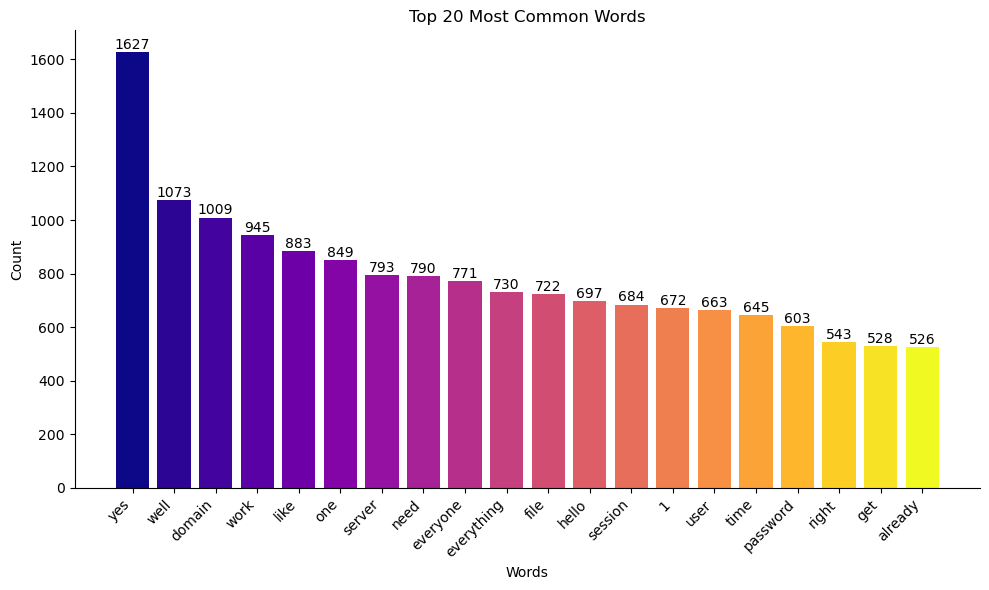

In [21]:
# Tokeniser les messages traités et compter les occurrences de mots
word_tokens = [word for message in df['Processed_Message'] for word in message.split()]
word_freq = Counter(word_tokens)

# Afficher les 20 mots les plus courants
common_words = word_freq.most_common(20)

# Extraction de mots et de leur nombre pour le tracé
words = [item[0] for item in common_words]
counts = [item[1] for item in common_words]

colors = plt.cm.plasma(np.linspace(0, 1, len(words)))

# Tracer le diagramme à barres avec des barres colorées
plt.figure(figsize=(10, 6))
bars = plt.bar(words, counts, color=colors)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 20 Most Common Words')

# Supprimer l'axe supérieur droit
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajouter des étiquettes au-dessus des barres
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 0.5, str(count), ha='center', va='bottom')

# Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Analyse de la fréquence des mots

Les 20 mots les plus courants et leur signification :

1. **yes (1627 occurrences)** : Cela indique que les réponses affirmatives ou les accords sont fréquents dans le chat.

2. **well (1073 occurrences)** : Souvent utilisé comme mot de remplissage ou pour commencer des phrases, suggérant des réponses réfléchies.

3. **domain (1009 occurrences)** : Indique des discussions relatives aux noms de domaine ou à des sujets liés au web. Il peut s'agir de l'achat ou de la vente de domaines, de la création de sites web ou de discussions techniques sur la configuration des domaines.

4. **work (945 occurrences)** : Les participants discutent souvent des tâches, des responsabilités ou de la fonctionnalité de certains outils ou procédures.

5. **like (883 occurrences)** : Il peut s'agir d'un bouche-trou ou d'une comparaison.

6. **One (849 occurrences)** : Référence possible à des éléments individuels, à des choix ou à une focalisation singulière sur des sujets spécifiques.

7. **server (793 occurrences)** : Suggère des discussions techniques sur l'installation, la configuration ou les problèmes des serveurs.

8. **need (790 occurrences)** : Indique des exigences, des demandes ou des dépendances.

9. **everyone (771 occurrences)** : Peut être utilisé pour s'adresser au groupe ou pour discuter des responsabilités.

10. **everything (730 occurrences)** : Indique des discussions approfondies, éventuellement sur des tâches ou des mises à jour.

11.**file (722 occurrences)** : Les discussions peuvent porter sur le partage, la modification ou l'accès à des fichiers.

12.**hello (697 occurrences)** : Salutation courante, suggérant l'ouverture d'une conversation.

13.**session (684 occurrences)** : Peut faire référence à des sessions de chat, à des sessions techniques ou à des sessions de travail.

14.**1 (672 occurrences)** :Peut être utilisé dans des listes, des énumérations ou comme une affirmation (par exemple, "1" pour "oui").

15.**user (663 occurrences)** :Discussions sur les utilisateurs finaux, les comptes d'utilisateurs ou les expériences des utilisateurs.

16.**time (645 occurrences)** :Indique des discussions sur la programmation, les délais ou les questions sensibles.

17.**password (603 occurrences)** :Indique des discussions sur la sécurité, l'accès ou l'authentification.

18.**right (543 occurrences)** :Peut être utilisé pour affirmer l'exactitude d'une information ou pour donner des instructions.

19.**get (528 occurrences)** :Indique des actions, comme dans acquérir, comprendre ou aller chercher.

20. **already (526 occurrences)** : Indique des actions passées ou des tâches accomplies.


### Résumé

L'analyse de la fréquence des mots nous permet de déduire que le chat implique une combinaison de discussions techniques (par exemple, "domaine", "serveur", "fichier", "session", "utilisateur", "mot de passe") et d'éléments de collaboration (par exemple, "tout le monde", "travail", "besoin"). La présence de mots tels que "bonjour", "oui" et "bien" suggère un ton semi-formel avec des salutations et des réponses affirmatives. 

La mention fréquente de termes techniques indique que les participants pourraient être en train de discuter de tâches, de projets ou de problèmes liés aux technologies de l'information. La combinaison de "domaine", "serveur", "utilisateur" et "mot de passe" suggère des sujets liés à l'hébergement, à la gestion de sites web ou à la cybersécurité. 

Cette analyse fournit une vue d'ensemble des thèmes et sujets du chat. D'autres analyses, comme la fréquence des bigrammes/trigrammes ou l'analyse des sentiments, peuvent fournir des informations plus approfondies sur les sujets spécifiques abordés et sur les intentions ou les sentiments des participants.

# <font color="#110896"> Bigrammes et trigrammes

Pour mieux comprendre les termes techniques et le jargon, il faudrait examiner une liste plus large de termes fréquents ou se pencher sur les bigrammes (combinaisons de deux mots) et les trigrammes (combinaisons de trois mots).

In [22]:
# Generate bigrams and trigrams from the word tokens
bigram_tokens = list(bigrams(word_tokens))
trigram_tokens = list(trigrams(word_tokens))

# Count occurrences of bigrams and trigrams
bigram_freq = Counter(bigram_tokens)
trigram_freq = Counter(trigram_tokens)

# Display the 20 most common bigrams and trigrams
common_bigrams = bigram_freq.most_common(20)
common_trigrams = trigram_freq.most_common(20)

print("*"*125)
print("Bigrams")
print("*"*125)
print(common_bigrams, end = "\n\n")
    
print("*"*125)
print("Trigrams")
print("*"*125)
print(common_trigrams)

*****************************************************************************************************************************
Bigrams
*****************************************************************************************************************************
[(('hello', 'everyone'), 260), (('let', 'u'), 259), (('good', 'morning'), 149), (('usertype', '1'), 134), (('1', 'username'), 134), (('tl1', 'tl1'), 125), (('default', 'share'), 116), (('found', 'bookmark'), 111), (('hello', 'hello'), 104), (('500', 'version'), 102), (('445', 'platform'), 101), (('platform', '500'), 101), (('long', 'time'), 96), (('new', 'year'), 90), (('█', '──'), 89), (('beacon', 'shell'), 86), (('──', '█'), 85), (('initial', 'beacon'), 82), (('8', 'byte'), 80), (('icmp', 'target'), 79)]

*****************************************************************************************************************************
Trigrams
********************************************************************************************

### Analyse des bigrammes et des trigrammes

Les bigrammes et les trigrammes permettent d'identifier les phrases communes ou les séquences de mots qui reviennent fréquemment ensemble. Cela permet de mieux comprendre les thèmes récurrents ou les sujets de discussion dans le chat. Analysons les résultats :

#### Bigrammes:

1. **('hello', 'everyone')**: Une salutation commune adressée au groupe.
2. **('let', 'u')**: Il s'agit probablement d'un "laissez-nous", indiquant un appel à l'action ou suggérant une décision ou une tâche collective.
3. **('good', 'morning')**: Une autre formule de salutation, indiquant que de nombreuses conversations peuvent commencer le matin.
4. **('usertype', '1')** et **('1', 'username')**: Il peut s'agir de termes techniques liés à l'identification ou au profil des utilisateurs.
5. **('tl1', 'tl1')**: L'utilisation répétée du terme "tl1" suggère qu'il s'agit d'un nom d'utilisateur.
6. **('default', 'share')**: Il s'agit peut-être d'une discussion sur les paramètres ou les autorisations de partage par défaut.
7. **('found', 'bookmark')**: Discussions autour de la découverte de certains signets ou liens sauvegardés.
8. **('500', 'version')** et **('445', 'platform')**:  Il s'agit de termes techniques, peut-être liés à des versions de logiciels ou à des plates-formes.
9. **('long', 'time')**: Ces termes peuvent faire référence à des durées ou indiquer que quelque chose n'a pas été discuté ou vu depuis un certain temps.
10. **('new', 'year')**: Indique des références temporelles ou des célébrations.
11. **('beacon', 'shell')**: Termes techniques ou de cybersécurité.
12. **('initial', 'beacon')**: Peut faire référence au signal ou à la communication initiale dans un contexte technique.
13. **('8', 'byte')** et **('icmp', 'target')**: Termes techniques éventuellement liés à la taille des données et à la communication en réseau. 

#### Trigrammes:

1. **('usertype', '1', 'username')**: Cette séquence suggère les détails ou les paramètres du profil de l'utilisateur.
2. **('tl1', 'tl1', 'tl1')**: Une fois de plus, le terme répété "tl1" signifie un nom d'utilisateur.
3. **('445', 'platform', '500')** and **('platform', '500', 'version')**: Ces problèmes sont probablement liés aux spécifications ou aux configurations de la plate-forme.
4. **('alive', 'read', '8')** and **('read', '8', 'byte')**: Il s'agit d'opérations techniques liées à la lecture des données.
5. **('domain', 'loomis', '445')**: "Loomis" peut être un nom de domaine ou un code de projet.
6. **('found', 'bookmark', 'without')**, **('bookmark', 'without', 'cred')**, et les trigrammes suivants : Ces trigrammes suggèrent des discussions sur des signets qui ont été découverts sans les informations d'identification nécessaires. Il peut s'agir d'un problème de sécurité ou d'accès.

### Résumé

Les bigrammes et les trigrammes donnent un aperçu des principaux thèmes du chat. Il y a des discussions techniques évidentes liées aux profils des utilisateurs, aux versions des logiciels, aux plates-formes et aux communications réseau. Plusieurs salutations et références temporelles suggèrent un mode de communication informel et opportun. Certains trigrammes font allusion à des problèmes potentiels de sécurité ou d'accès, comme des signets sans identifiants, ce qui indique que les participants au chat pourraient discuter de vulnérabilités ou de sujets particulièrements préoccupants.

L'analyse de ces paires et triplets de mots fréquents permet de dresser un tableau plus précis de la nature de la discussion et des préoccupations ou centres d'intérêt des participants.

# <font color="#110896"> Analyse des sentiments

L'analyse des sentiments est une technique de traitement du langage naturel (NLP) utilisée pour déterminer si un texte (dans ce cas, un message de chat) est positif, négatif ou neutre. En appliquant cette analyse à notre ensemble de données, nous pouvons obtenir des informations sur l'humeur générale ou le ton des conversations.

#### Méthode:

La bibliothèque **TextBlob** a été utilisée pour analyser le sentiment de chaque message. TextBlob évalue la polarité du sentiment, avec des valeurs allant de -1 (le plus négatif) à 1 (le plus positif). Une valeur de 0 indique la neutralité.

In [23]:
def compute_sentiment_textblob(text):
    analysis = TextBlob(text)
    # Classer la polarité du sentiment
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df['TextBlob_Sentiment'] = df['Processed_Message'].apply(compute_sentiment_textblob)

df[['Processed_Message', 'TextBlob_Sentiment']].head(6)

,Processed_Message,TextBlob_Sentiment
0,admin,Neutral
1,adminnengohmahch8,Neutral
2,hello,Neutral
3,good afternoon everyone,Positive
4,taurus,Neutral
5,virgo,Neutral


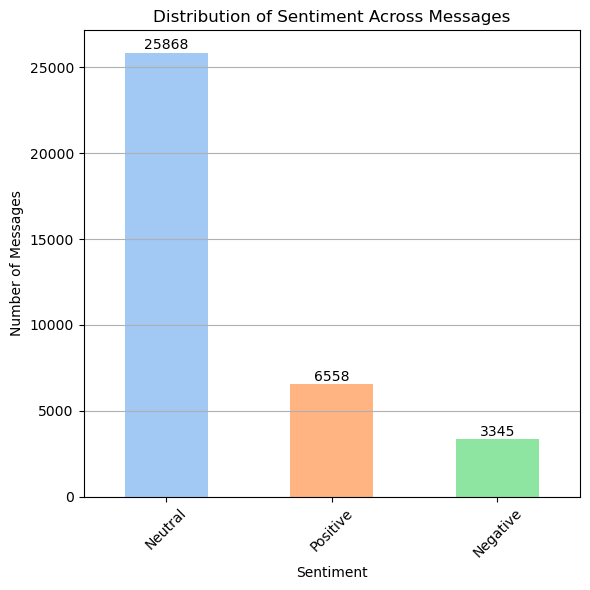

In [24]:
# Compter les messages par sentiment
sentiment_counts = df['TextBlob_Sentiment'].value_counts()

# Créer une palette de couleurs pour les barres
colors = sns.color_palette('pastel')[0:len(sentiment_counts)]

# Tracer la distribution des sentiments 
plt.figure(figsize=(6, 6))
sentiment_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Sentiment Across Messages')
plt.xlabel('Sentiment')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Ajout d'étiquettes au-dessus des barres
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Observations:

1. **Dominance neutre**: Une grande partie des messages, 25 868 exactement, ont été jugés neutres. Cela suggère que de nombreuses conversations dans le chat étaient objectives, basées sur des faits, ou ne véhiculaient pas d'émotions fortes. C'est typiquement le cas des chats techniques ou informatifs.
  
2. **Conversations positives**: Il y a eu 6 558 messages avec un sentiment positif. Cela indique que les participants ont souvent partagé des commentaires positifs, des solutions ou se sont simplement livrés à des échanges amicaux.
  
3. **Présence de sentiments négatif**: 3 345 messages ont été classés comme négatifs. Cela peut indiquer des difficultés rencontrées, des désaccords ou des discussions sur des problèmes et des questions. Il est essentiel d'approfondir ces messages pour comprendre le contexte et les raisons spécifiques de la négativité.

#### Analyse visuelle:

Le diagramme à barres intitulé "Distribution des sentiments dans les messages" représente visuellement la distribution des sentiments. La prédominance des messages neutres est évidente, suivie par les sentiments positifs puis négatifs. Cette représentation visuelle offre une vue d'ensemble rapide et claire de la répartition des sentiments dans le chat.


# <font color="#110896"> Répartition des messages par expéditeur

L'analyse de la distribution des messages par expéditeur permet de comprendre la participation des individus à la conversation. Elle donne un aperçu des participants les plus actifs, du volume de leurs contributions et, éventuellement, de leur influence ou de leur rôle dans la discussion.

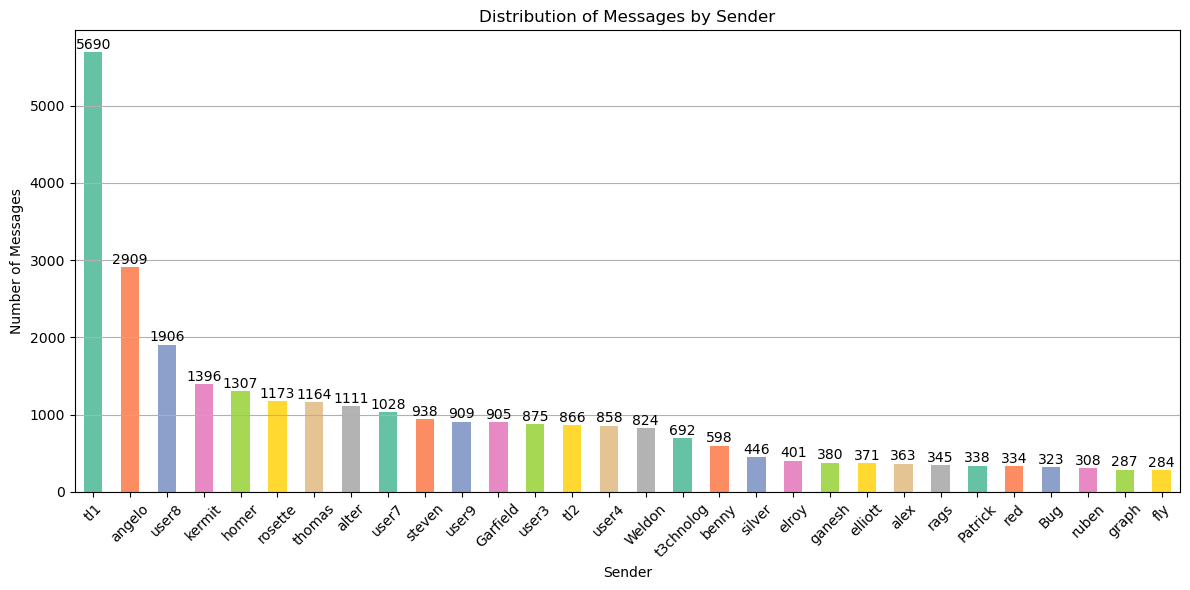

In [25]:
# Compter les messages par expéditeur
message_counts = df['Sender'].value_counts().head(30)

# Créer une palette de couleurs pour les barres
colors = sns.color_palette('Set2', len(message_counts))

# Tracer la distribution des messages à l'aide de barres colorées
plt.figure(figsize=(12, 6))
message_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Messages by Sender')
plt.xlabel('Sender')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Ajouter des étiquettes au-dessus des barres
for i, count in enumerate(message_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### Observations:

1. **Dominance de 'tl1'**:  L'expéditeur 'tl1' a envoyé le plus grand nombre de messages, soit 5 690. Cela indique que 'tl1' est un participant très actif dans le chat et qu'il peut avoir un rôle ou une influence significative sur les sujets de conversation.
  
2. **Haute activité de 'angelo'**:  'angelo' est le deuxième participant le plus actif avec 2 909 messages. Cela suggère que 'angelo', ainsi que 'tl1', joue un rôle central dans les discussions.

3. **Diversité des participants**: Bien que 'tl1' et 'angelo' soient les plus dominants, il y a un large éventail de participants avec des niveaux d'activité variables. Certains sont très actifs, tandis que d'autres contribuent moins. Cette diversité est le signe d'une discussion large et inclusive avec de nombreux contributeurs.

4. **Analyse visuelles**: Le diagramme à barres intitulé "Distribution des messages par expéditeur" présente visuellement la distribution. La chute brutale après les deux premiers expéditeurs ('tl1' et 'angelo') indique leur contribution substantielle par rapport aux autres participants.

#### Conclusion:

Comprendre la distribution des messages par expéditeur peut donner un aperçu de la dynamique de la discussion. Des participants clés comme 'tl1' et 'angelo' peuvent être à l'origine de la majorité des discussions, tandis que d'autres contribuent de manière sporadique. Il peut être utile de se concentrer sur les messages de ces participants clés pour comprendre les principaux thèmes ou objectifs de la discussion.

## <font color="#110896"> Focus sur les deux utilisateurs les plus actifs (analyse des utilisateurs)

In [26]:
# Identifier les deux expéditeurs les plus actifs
top_senders = message_counts.head(2).index.tolist()
top_senders

['tl1', 'angelo']

### Termes les plus fréquents pour l'expéditeur 'tl1'

L'analyse des termes les plus fréquents utilisés par un expéditeur 'tl1' peut fournir des indications sur les principaux sujets dont il discute, ses préoccupations ou son rôle dans la conversation.

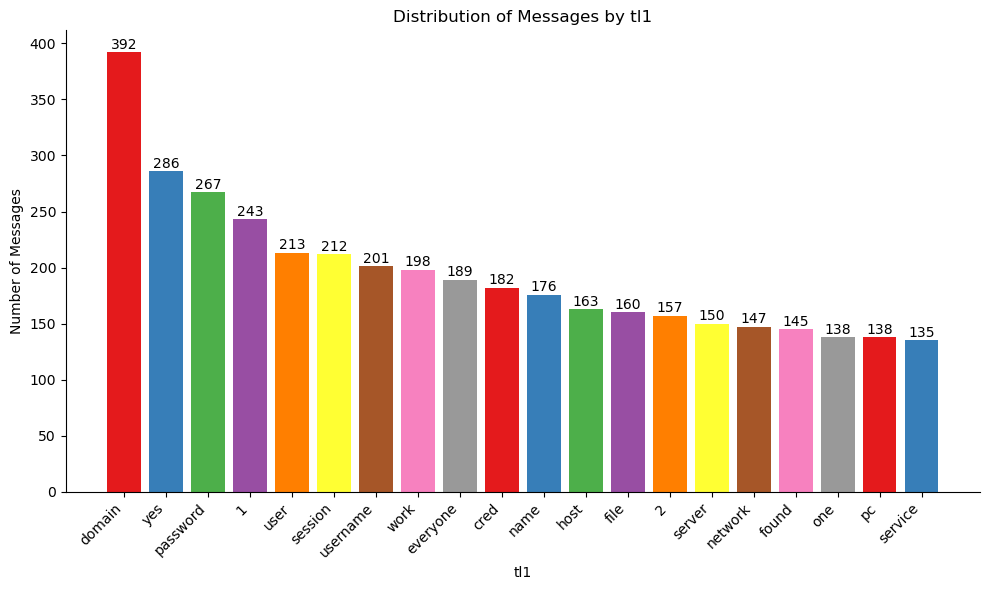

In [27]:
# Extraire les termes les plus fréquents pour l'expéditeur "tl1".
tl1_messages = df[df['Sender'] == 'tl1']['Processed_Message']
tl1_tokens = [word for message in tl1_messages for word in message.split()]
tl1_word_freq = Counter(tl1_tokens)

# Afficher les 20 mots les plus courants pour "tl1".
tl1_common_words = tl1_word_freq.most_common(20)

# Extraction des mots et de leur nombre pour la représentation graphique
words = [item[0] for item in tl1_common_words]
counts = [item[1] for item in tl1_common_words]

colors = sns.color_palette('Set1', len(words))

# Tracer le diagramme à barres avec des barres colorées
plt.figure(figsize=(10, 6))
bars = plt.bar(words, counts, color=colors)
plt.title('Distribution of Messages by tl1')
plt.xlabel('tl1')
plt.ylabel('Number of Messages')

# Supprimer l'axe supérieur droit
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajout d'étiquettes au-dessus des barres
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 0.5, str(count), ha='center', va='bottom')

# Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Observations:

1. **Vocabulaire technique**: Des mots comme "domain", "password", "user", "session", "username", "server", "network", "file", "pc", et "service" indiquent que les conversations sont de nature technique. Il semble que 'tl1' soit impliqué dans des discussions liées à l'informatique ou aux réseaux.

2. **Réponses affirmative**: La fréquence élevée du mot "oui" suggère que 'tl1' fournit souvent des réponses affirmatives ou accuse réception des messages des autres.

3. **Prévalence des informations d'identification**: Des mots comme "password" et "cred" (peut-être l'abréviation de "credentials") figurent parmi les termes les plus fréquents, ce qui indique que "tl1" discute ou traite souvent de détails de connexion ou de questions d'authentification.

4. **Échange avec tout le monde**: Le mot "everyone" figure également parmi les termes les plus fréquents, ce qui suggère que "tl1" s'adresse souvent à l'ensemble du groupe, éventuellement pour donner des instructions, des mises à jour ou des messages d'ordre général.

5. **Références Numériques**: La présence de chiffres tels que "1" et "2" parmi les termes les plus fréquents peut indiquer une référence à des étapes, des versions, des types d'utilisateurs spécifiques ou d'autres éléments numérotés dans la conversation.

#### Conclusion:

Les termes fréquemment utilisés par "tl1" suggèrent qu'il joue un rôle technique dans le chat, peut-être en tant qu'administrateur informatique, expert en réseau ou quelqu'un qui fournit des conseils sur des questions liées au système. La compréhension de ces termes peut fournir un contexte pour la dominance de 'tl1' dans le nombre de messages et la nature de ses contributions au chat.

### Termes les plus fréquents pour l'expéditeur 'Angelo'

En évaluant les mots les plus courants utilisés par "angelo", nous pouvons obtenir des informations sur le style de communication de l'individu, ses sujets d'intérêt, ses émotions et les rôles qu'il peut jouer dans la conversation.

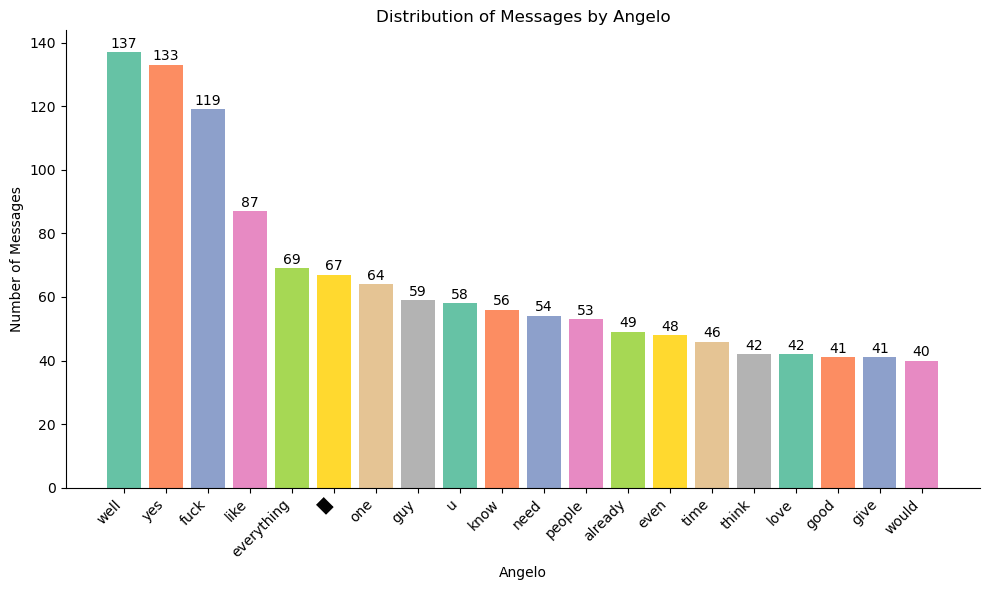

In [28]:
#  Extraire les termes les plus fréquents pour l'expéditeur "angelo".
angelo_messages = df[df['Sender'] == 'angelo']['Processed_Message']
angelo_tokens = [word for message in angelo_messages for word in message.split()]
angelo_word_freq = Counter(angelo_tokens)

# Afficher les 20 mots les plus courants pour 'angelo'
angelo_common_words = angelo_word_freq.most_common(20)

# Extraction des mots et de leur nombre pour la représentation graphique
words = [item[0] for item in angelo_common_words]
counts = [item[1] for item in angelo_common_words]

colors = sns.color_palette('Set2', len(words))

# Tracer le diagramme à barres avec des barres colorées
plt.figure(figsize=(10, 6))
bars = plt.bar(words, counts, color=colors)
plt.title('Distribution of Messages by Angelo')
plt.xlabel('Angelo')
plt.ylabel('Number of Messages')

# Supprimer l'axe supérieur droit
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajout d'étiquettes au-dessus des barres
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 0.5, str(count), ha='center', va='bottom')

# Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Observations:

1. **Vocabulaire émotif**: La présence de mots comme "fuck", "love" et "like" suggère que "angelo" est expressif et qu'il peut utiliser un langage fort pour transmettre des sentiments ou souligner des points.

2. **Accord général**: L'utilisation fréquente de "yes" et "well" indique que 'angelo' est souvent d'accord avec les autres ou qu'il introduit ses déclarations sur un ton affirmatif.

3. **Opinions et pensées personnelles**:  Des mots tels que "think", "know", "like", et "need" impliquent que 'angelo' partage souvent des opinions personnelles, des croyances, ou des exigences dans le chat.

4. **Références sociales**: L'utilisation de mots tels que "guy", "people" et "u" montre que 'angelo' fait souvent référence ou parle d'autres participants ou groupes de personnes.

5. **Références temporelles et de statut**: Les mots "already", "time" et "everything" peuvent indiquer qu'"angelo" discute de l'état d'avancement des tâches, de la progression des événements ou qu'il réfléchit aux discussions passées.

6. **Rédactions ou caractères spéciaux**: Le caractère "█" peut représenter des informations expurgées, des espaces réservés ou faire partie d'un formatage spécial. Son utilisation fréquente pourrait indiquer qu'"angelo" partage souvent des contenus contenant des informations spécifiques cachées ou masquées, ou qu'il s'y réfère.

#### Conclusion:

Angelo semble être un participant expressif et plein d'opinions dans le chat. Il se réfère souvent aux autres, partage ses convictions personnelles et utilise un langage fort pour souligner certains points ou exprimer ses émotions. Comprendre les termes fréquents utilisés par 'angelo peut aider à évaluer son style de communication et la nature de ses interactions sur le chat.

# <font color="#110896"> Analyse des tendances

La tendance du sentiment au fil du temps est visualisée pour comprendre l'évolution de l'humeur du chat.

In [29]:
# Analyser le sentiment véhiculé dans les messages
df['Sentiment_Polarity'] = df['Message'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

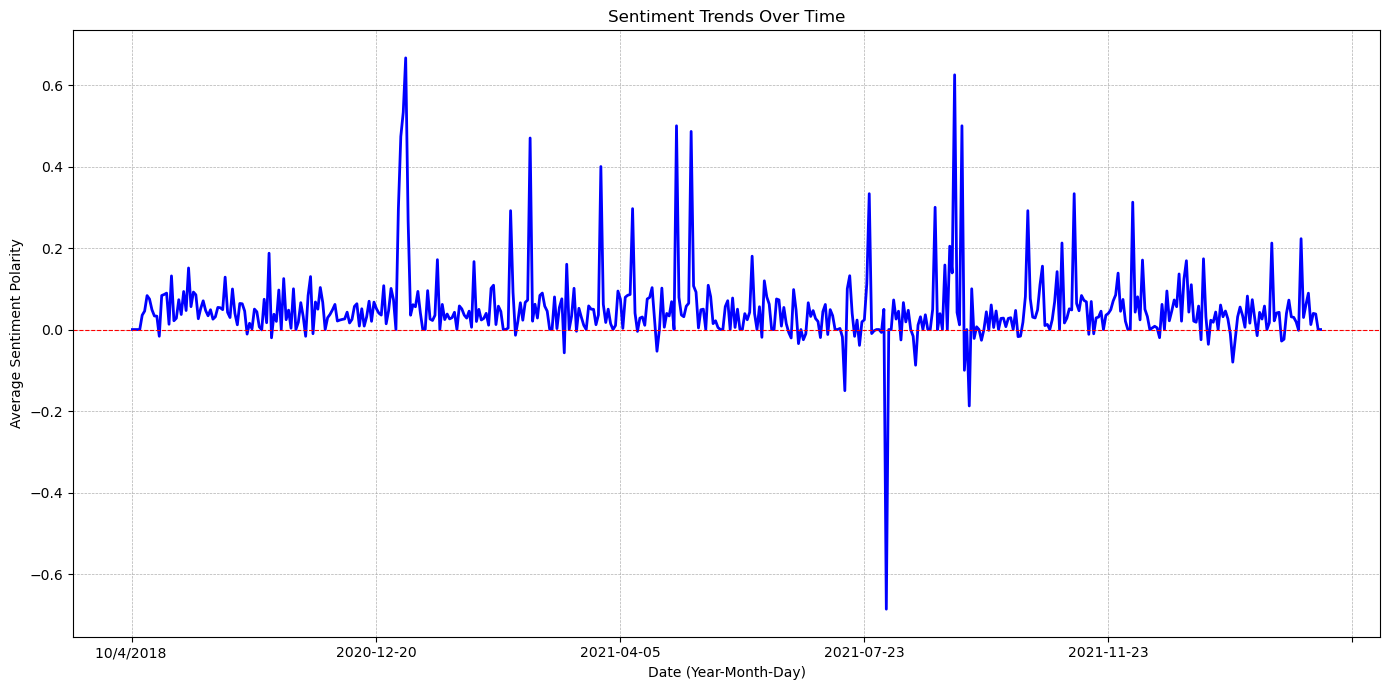

In [30]:
# Convertir la colonne "Date" en chaînes de caractères
df['Date_Str'] = df['Date'].astype(str)

# Extraire l'année, le mois et le jour de la colonne "Date_Str" pour créer une chaîne de date composite.
df['Composite_Date_Str'] = df['Date_Str'].str[:10]

# Regrouper par 'Composite_Date_Str' et calculer le score moyen de sentiment
sentiment_by_composite_date_str = df.groupby('Composite_Date_Str')['Sentiment_Polarity'].mean()

# Tracer la tendance du sentiment à l'aide de la chaîne de dates composite
plt.figure(figsize=(14, 7))
sentiment_by_composite_date_str.plot(linewidth=2, color='blue')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date (Year-Month-Day)')
plt.ylabel('Average Sentiment Polarity')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Vue d'ensemble :
Le graphique visualise la polarité moyenne des sentiments des messages pour chaque jour. L'axe des x représente la date (de la plus ancienne à la plus récente), tandis que l'axe des y représente la polarité moyenne du sentiment. La polarité du sentiment est une valeur comprise entre -1 (complètement négatif) et 1 (complètement positif), 0 étant neutre.

### Observations:
1. **Sentiment neutre**: La ligne pointillée rouge à y=0 représente un sentiment neutre. Une grande partie des données fluctue autour de cette ligne, ce qui suggère que de nombreuses conversations quotidiennes ont un ton neutre.
  
2. **Pics positifs**: Certains jours, la polarité du sentiment dépasse 0,2, ce qui suggère que la conversation était plus positive ces jours-là. Ces pics peuvent être dus à des nouvelles positives, à des opérations réussies ou à d'autres événements positifs.

3. **Creux négatifs**: Le nombre de jours où le sentiment descend en dessous de -0,2 est plus faible. Ces creux indiquent des jours où le ton de la conversation est plus négatif. Ces sentiments négatifs peuvent résulter de désaccords, de problèmes rencontrés ou d'événements négatifs.

4. **Fluctuations**: Le graphique montre des fluctuations régulières du sentiment. Certaines de ces fluctuations peuvent être liées à des événements spécifiques, tandis que d'autres peuvent simplement correspondre au flux et au reflux naturels de la conversation.

### Implications:
La compréhension des tendances en matière de sentiment peut donner des indications sur l'humeur générale des participants au chat au fil du temps. Par exemple, un sentiment positif constant peut indiquer de la satisfaction, des activités réussies ou de l'optimisme. À l'inverse, un sentiment négatif peut indiquer des difficultés, des désaccords ou du pessimisme.

En établissant une corrélation entre des pics ou des creux spécifiques et le contenu des messages ces jours-là, il est possible d'obtenir des informations plus approfondies sur les causes d'un tel changement de sentiment.

# <font color="#110896"> Reconnaissance d'entités

Nous traitons le texte en utilisant les capacités de reconnaissance des entités nommées (NER) de spaCy, puis nous affichons les 40 entités les plus courantes ainsi que leur nombre.

In [31]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.0/12.8 MB 262.6 kB/s eta 0:00:49
     --------------------------------------- 0.0/12.8 MB 245.8 kB/s eta 0:00:52
     --------------------------------------- 0.1/12.8 MB 326.8 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 392.2 kB/s eta 0:00:33
     --------------------------------------- 0.1/12.8 MB 400.9 kB/s eta 0:00:32
      -------------------------------------- 0.2/12.8 MB 499.5 kB/s eta 0:00:26
      -------------------------------------- 0.3/12.8 MB 655.4 kB/s eta 0:00:20
      -------------------------------------- 0.3/12.8 MB 655.2 kB/s eta 0:00:20
     - ------------------------------------- 0.3/12.8 MB 720.5 kB/s eta 0:00:18
     - ------------------------------------- 0.4/12.8 MB

In [32]:
#  Joindre la liste des mots en une seule chaîne de caractères
text = ' '.join(word_tokens)

# Charger le modèle spaCy
nlp = spacy.load("en_core_web_sm")

# Augmenter la limite max_length
nlp.max_length = 2000000  

# Traiter le texte avec spaCy
doc = nlp(text)

# Extraire les entités et leurs étiquettes
entity_counts = Counter([(ent.text, ent.label_) for ent in doc.ents])

#  Entités les plus courantes
most_common_entities = entity_counts.most_common(40)

print("Top 40 Most Common Entities:")
for entity, count in most_common_entities:
    print(f"Entity: {entity}, Count: {count}")


Top 40 Most Common Entities:
Entity: ('one', 'CARDINAL'), Count: 531
Entity: ('1', 'CARDINAL'), Count: 501
Entity: ('2', 'CARDINAL'), Count: 343
Entity: ('byte', 'ORG'), Count: 301
Entity: ('░░', 'DATE'), Count: 247
Entity: ('3', 'CARDINAL'), Count: 238
Entity: ('today', 'DATE'), Count: 235
Entity: ('first', 'ORDINAL'), Count: 218
Entity: ('4', 'CARDINAL'), Count: 190
Entity: ('445', 'CARDINAL'), Count: 171
Entity: ('100', 'CARDINAL'), Count: 154
Entity: ('0', 'CARDINAL'), Count: 153
Entity: ('tomorrow', 'DATE'), Count: 152
Entity: ('yesterday', 'DATE'), Count: 125
Entity: ('second', 'ORDINAL'), Count: 123
Entity: ('5', 'CARDINAL'), Count: 122
Entity: ('500', 'CARDINAL'), Count: 122
Entity: ('10', 'CARDINAL'), Count: 119
Entity: ('8', 'CARDINAL'), Count: 116
Entity: ('two', 'CARDINAL'), Count: 114
Entity: ('░░', 'CARDINAL'), Count: 113
Entity: ('morning', 'TIME'), Count: 105
Entity: ('russian', 'NORP'), Count: 89
Entity: ('6', 'CARDINAL'), Count: 84
Entity: ('microsoft', 'ORG'), Count:

1. **Types d'entités et libellés:**
   - Les résultats montrent différents types d'entités et leurs étiquettes correspondantes, telles que 'CARDINAL,' 'ORG,' 'DATE,' 'PERSON,' 'NORP,' 'TIME,' 'GPE,' etc. Chaque type d'entité représente une catégorie différente d'entités nommées.
   
2. **Les 40 entités les plus courantes:**
   - Ce code affiche les entités les plus fréquentes dans le texte donné. Ces entités sont classées en fonction de leur fréquence, les entités les plus courantes apparaissant en tête de liste.


3. **Exemples de types d'entités:**
   - Voici quelques exemples de types d'entités et de leur signification:
     - 'CARDINAL': Chiffres, nombres ou séquences numériques ('one,' '1,' '445,' '100,' etc.).
     - 'ORG': Organisations, entreprises ou institutions ('byte,' 'Microsoft,' 'dns,' etc.).
     - 'DATE': Dates ou expressions relatives aux dates ('today,' 'tomorrow,' 'new year,' etc.).
     - 'PERSON': Noms de personnes ('Steve Jobs,' 'jjones102742145,' 'user9,' etc.).
     - 'NORP': Nationalités, groupes religieux ou politiques ('Russian,' 'Russia,' 'russian,' etc.).
     - 'TIME': EXPRESSIONS TEMPORELLES  ('morning').
     - 'GPE': ENTITÉS GÉOPOLITIQUES, telles que des pays ou des villes ('California,' 'Russia').


Les résultats fournis montrent les 40 entités les plus courantes et leur nombre respectif extraits du texte d'entrée. Analysons ces résultats :



4. **Explanation of the Top Entities:**

   - `'one', '1', '2', '3', '4', '5', '6', '7', '8'`: Ces entités sont reconnues comme des entités "CARDINALES", représentant diverses valeurs ou séquences numériques dans le texte. Par exemple, "one" apparaît 531 fois, "1" apparaît 501 fois, etc.

   - `'byte'`: Cette entité est étiquetée comme "ORG", ce qui indique qu'elle est reconnue comme un nom d'organisation. Dans le contexte du texte, il peut s'agir d'une entreprise ou d'une entité nommée "byte" qui est mentionnée 301 fois..

   - `'░░'`: Cette entité est étiquetée comme "DATE", ce qui suggère qu'elle peut représenter des informations liées à la date. Le contexte du texte serait nécessaire pour comprendre sa signification.

   - `'today', 'tomorrow', 'yesterday'`: Ils sont reconnus comme des entités "DATE", indiquant des références à des jours spécifiques. "Today" apparaît 235 fois, "tomorrow" 152 fois et "yesterday" 125 fois.

   - `'first', 'second'`: Ces entités sont reconnues comme des entités "ORDINAL", représentant des nombres ordinaux. Par exemple, "first" apparaît 218 fois et "second" 123 fois.

   - `'microsoft', 'user3', 'dns'`: Ces entités sont reconnues comme des entités "ORG", ce qui suggère qu'il s'agit de noms d'organisations. Par exemple, "microsoft" apparaît 77 fois, "user3" 62 fois et "dns" 42 fois.

   - `'jjones102742145', 'user9'`: Ces entités sont reconnues comme des entités "PERSON", indiquant des noms de personnes ou des noms d'utilisateurs. Par exemple, 'jjones102742145' et 'user9' apparaissent chacun 68 fois.

   - `'russian', 'russia'`: Ils sont reconnus comme des entités "NORP" et "GPE", respectivement. Le terme "russian" fait probablement référence à une nationalité ou à un groupe, tandis que le terme "russia" représente une entité géopolitique. Ils apparaissent respectivement 89 et 50 fois.

5. **Variété des types d'entités:**
   - Les résultats montrent une grande variété de types d'entités, y compris des nombres, des organisations, des dates, des individus, des nationalités, des époques et des entités géopolitiques.

7. **Prise en compte des caractères spéciaux:**
   - Il convient de noter que les résultats incluent des entités telles que "░░" et "░", qui sont reconnues comme des entités mais dont la signification n'est pas toujours claire sans contexte supplémentaire. Les caractères spéciaux sont difficiles à interpréter sans contexte.


# <font color="#110896"> Analyse de cooccurrence

L'analyse de la cooccurrence des mots se concentre sur la fréquence à laquelle des paires de mots apparaissent ensemble dans une fenêtre de mots donnée. Dans ce contexte, la taille de la fenêtre est de 5, ce qui signifie que nous prenons en compte les 5 mots précédant et suivant chaque mot pour vérifier les cooccurrences.

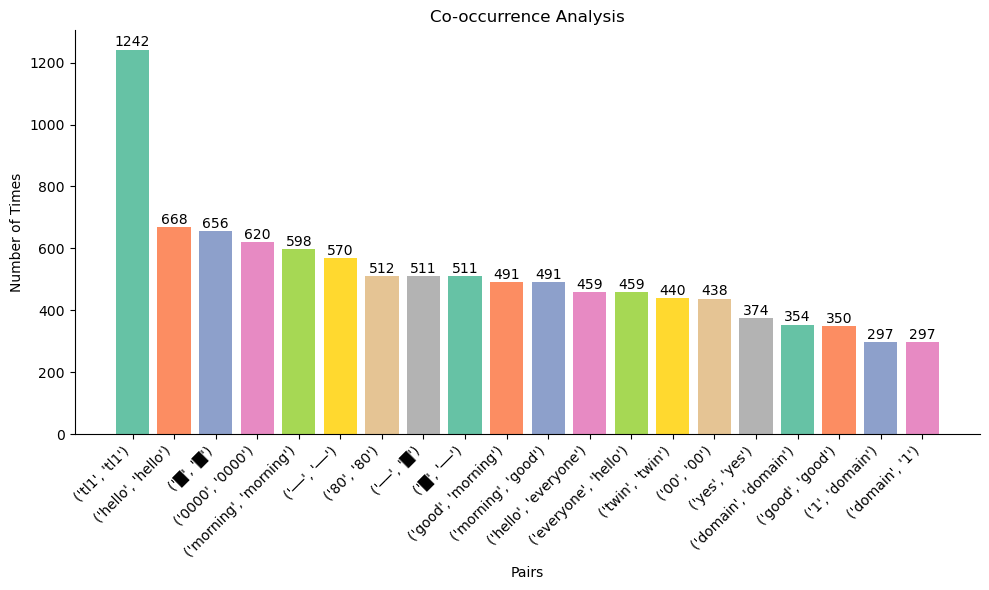

In [33]:
def get_cooccurrences(tokens, window_size=5):
    """Fonction permettant d'obtenir les cooccurrences de mots à l'intérieur d'une fenêtre donnée."""
    cooccurrences = Counter()
    
    for idx, token in enumerate(tokens):
        # Définir la fenêtre des mots cooccurrents
        start_idx = max(0, idx - window_size)
        end_idx = min(len(tokens), idx + window_size + 1)
        
        # Extraction des mots cooccurrents à l'intérieur de la fenêtre
        cooccur_tokens = tokens[start_idx:idx] + tokens[idx+1:end_idx]
        for co_token in cooccur_tokens:
            cooccurrences[(token, co_token)] += 1
            
    return cooccurrences

# Obtenir les cooccurrences pour l'ensemble de la liste des mots-clés
cooccurrences = get_cooccurrences(word_tokens)

# Affiche les 20 paires de cooccurrences les plus fréquentes
common_cooccurrences = cooccurrences.most_common(20)
# Extraire les paires de mots et leur nombre
word_pairs = [f"{pair[0]}" for pair in common_cooccurrences]
counts = [pair[1] for pair in common_cooccurrences]

colors = sns.color_palette('Set2', len(words))

# Tracer le diagramme à barres avec des barres colorées
plt.figure(figsize=(10, 6))
bars = plt.bar(word_pairs, counts, color=colors)
plt.title('Co-occurrence Analysis')
plt.xlabel('Pairs')
plt.ylabel('Number of Times')

# Enlever l'axe supérieur droit
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajouter des étiquettes au-dessus des barres
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 0.5, str(count), ha='center', va='bottom')

# Faire pivoter les étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


#### Observations:

1. **Mots répétitifs**: De nombreuses paires de mots comme "tl1 - tl1", "hello - hello", et "morning - morning" indiquent la répétition du même mot. Ces répétitions peuvent être dues à un formatage spécifique, à des répétitions emphatiques ou à des messages générés par le système.

2. **Caractères spéciaux et caractères de remplacement**: La paire "█ - █" and "── - ──" suggère que certains caractères ou espaces réservés apparaissent souvent ensemble. Cela peut indiquer un style de mise en forme ou un contenu expurgé.

3. **Salutations**: La paire "good - morning" et son inverse "morning - good" implique que la salutation "good morning" est une phrase couramment utilisée dans le chat.

4. **Références à des domaines**: La paire "1 - domain" et son inverse "domain - 1" suggèrent qu'il y a des discussions fréquentes liées à des domaines, peut-être des configurations ou des paramètres de domaine associés à un identifiant spécifique "1".

#### Conclusion:

L'analyse des cooccurrences donne un aperçu des phrases et des schémas courants dans les données de chat. Les paires de mots répétitifs peuvent indiquer des messages structurés ou automatisés, tandis que les combinaisons de mots spécifiques peuvent mettre en évidence des sujets de discussion communs. La reconnaissance de ces schémas peut s'avérer précieuse pour comprendre la nature du chat, les sujets fréquemment abordés et le style de communication.

# <font color="#110896"> Modélisation thématique

Latent Dirichlet Allocation (LDA) est une technique puissante de modélisation thématique. Elle permet d'identifier automatiquement les sujets au sein d'un corpus de données textuelles. Dans cette analyse, LDA a été utilisée pour identifier les sujets de discussion potentiels dans les données de chat. Voici les sujets identifiés :

1. **Comprendre les thèmes et les sujets discutés**: Cet objectif peut être atteint grâce à la modélisation des sujets. La modélisation des sujets est une méthode d'apprentissage non supervisée utilisée pour identifier des sujets dans une collection de documents. Une approche courante consiste à utiliser la méthode LDA (Latent Dirichlet Allocation).

2. **Prédire les intentions ou les actions futures**: C'est un peu plus difficile, surtout en l'absence de données étiquetées indiquant les intentions passées qui ont conduit à des actions réelles. Toutefois, nous pouvons utiliser des méthodes heuristiques. Par exemple, si nous identifions des sujets liés à des activités potentiellement malveillantes, nous pouvons les signaler pour examen. Nous pouvons également rechercher des mots-clés ou des phrases spécifiques susceptibles d'indiquer une intention.

Commençons par la **modélisation des sujets** pour comprendre les thèmes et les sujets abordés.

### Modélisation de sujets à l'aide de LDA:
J'utilise LDA pour extraire des sujets potentiels des journaux de discussion. Cela va donner une idée des principaux thèmes abordés dans les conversations. Une fois que nous avons les sujets, nous pouvons explorer le contenu de chaque sujet pour comprendre son contexte.

Voici les étapes à suivre :

1. **Vectorisation**: Conversion des messages traités en une matrice de comptage de jetons à l'aide de CountVectorizer.
2. **Entraînement du modèle LDA**: Utilisation de la matrice du nombre de mots pour entraîner le modèle LDA et identifier les sujets potentiels.
3. **Afficher les sujets**: Pour chaque sujet identifié, j'afficherai les principaux mots associés à ce sujet.


In [34]:
# Définir le nombre de sujets que nous voulons extraire
n_topics = 5

# Vectorisation
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf = vectorizer.fit_transform(df['Processed_Message'])
tf_feature_names = vectorizer.get_feature_names_out()

# Entraînement du modèle LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=0)
lda_model.fit(tf)

# Extraire et afficher les sujets et leurs mots clés
topics = {}
for topic_idx, topic in enumerate(lda_model.components_):
    topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-15 - 1:-1]]

# imprimer les mots-clés de chaque sujet  
for topic, words in topics.items():
    star_line = "*" * 40
    print(star_line)
    center_text = f"{'Topic ' + str(topic):^40}"
    print(center_text)
    print(star_line)
    for i, word in enumerate(words):
        print(f"{i + 1}. {word}")
    print(star_line)

****************************************
                Topic 0                 
****************************************
1. work
2. password
3. check
4. admin
5. username
6. ping
7. credit
8. make
9. question
10. morning
11. cred
12. add
13. kind
14. change
15. come
****************************************
****************************************
                Topic 1                 
****************************************
1. server
2. user
3. file
4. session
5. beacon
6. byte
7. new
8. process
9. command
10. look
11. guy
12. share
13. account
14. login
15. rdp
****************************************
****************************************
                Topic 2                 
****************************************
1. yes
2. domain
3. need
4. network
5. good
6. host
7. write
8. try
9. vpn
10. understand
11. 445
12. net
13. pm
14. version
15. administrator
****************************************
****************************************
                Topic 3              

#### Sujet 0:
- **Mots Clés**: work, password, check, admin, username, ping, credit, make, question, morning, cred, add, kind, change, come
- **Interprétation**: Ce sujet semble tourner autour de discussions liées au travail, y compris des questions relatives aux mots de passe, aux comptes d'utilisateurs et à diverses tâches administratives.

#### Sujet 1:
- **Mots Clés**: server, user, file, session, beacon, byte, new, process, command, look, guy, share, account, login, rdp
- **Interprétation**: Cette rubrique est liée à la gestion des serveurs et aux interactions avec les utilisateurs. Elle comprend des termes tels que "server", "user", "file" et "session", suggérant des discussions sur les configurations du serveur, les sessions des utilisateurs et les commandes.

#### Sujet 2:
- **Mots Clés**: yes, domain, need, network, good, host, write, try, vpn, understand, 445, net, pm, version, administrator
- **Interprétation**: Ce sujet semble concerner divers aspects techniques, notamment les domaines, les réseaux, les réseaux privés virtuels (VPN) et éventuellement l'administration du système. Des termes comme "domain", "network" et "vpn" indiquent des discussions techniques.

#### Sujet 3:
- **Mots Clés**: like, time, tl1, error, pc, say, remote, working, read, port, year, alive, day, target, want
- **Interprétation**: Cette rubrique contient des termes liés à des discussions générales sur l'heure, les erreurs, l'accès à distance et l'état du système. Elle semble couvrir un large éventail de sujets et peut représenter des conversations plus décontractées dans notre contexte.

#### Sujet 4:
- **Mots Clés**: hello, right, ok, know, let, group, fuck, access, way, service, window, hash, run, use, today
- **Interprétation**: Cette rubrique comprend des phrases et des termes courants de conversation, indiquant des discussions générales, des salutations ("hello"), et éventuellement des discussions sur l'accès à des services ou à des logiciels.

#### Observations:

- Ces sujets couvrent un large éventail de discussions, des questions techniques (sujets 0, 1, 2) aux conversations générales et aux salutations (sujets 3, 4).
- Certains sujets peuvent représenter des domaines d'expertise ou d'intérêt spécifiques au sein du groupe de discussion.
- Les sujets identifiés peuvent être utiles pour organiser et comprendre le contenu des données de chat, en facilitant la recherche de discussions ou de thèmes spécifiques.

La modélisation des sujets peut aider à automatiser la catégorisation de grands volumes de données textuelles, facilitant ainsi l'extraction d'informations et de connaissances significatives.

# <font color="#110896"> Prédiction des intentions

Dans cette analyse, des mots-clés et des phrases spécifiques ont été utilisés pour identifier les messages susceptibles d'indiquer des intentions malveillantes ou des discussions liées au piratage, aux cyberattaques ou à d'autres activités potentiellement nuisibles. Voici quelques-uns des messages signalés qui contiennent ces mots-clés :

In [36]:
# une liste de mots-clés/phrases qui pourraient indiquer certaines intentions
keywords = [
    "attack", "exploit", "break into", "hack", "bypass", "infiltrate", 
    "malware", "ransomware", "phishing", "breach", "compromise", "exfiltrate data"
]

# Marquer les messages qui contiennent l'un des mots-clés
flagged_messages = df[df['Processed_Message'].str.contains('|'.join(keywords), case=False, na=False)]

# Extraire un sous-ensemble de messages marqués pour examen
subset_flagged_messages = flagged_messages[['Date', 'Sender', 'Message']].head(20)
subset_flagged_messages

,Date,Sender,Message
181,2021-07-14T12:25:31.162Z,fish,``` REvil ransomware hackers linked to Russia ...
182,2021-07-14T04:59:00.962Z,frances,guys who have recently connected - send me the...
186,2021-07-13T19:12:50.868Z,frances,@all guys who recently connected - send me the...
189,2021-07-12T10:18:59.887Z,frances,guys who have recently connected - send me the...
194,2021-07-12T08:22:56.352Z,frances,Your backup jabber on the public server (explo...
559,2021-09-27T12:54:03.607Z,benny,"biohacker Sergey, that's FIVE!))"
566,2021-09-27T12:34:30.409Z,kermit,``` //vc.ru/future/26886-personal-biohacking ```
599,2021-09-27T11:21:33.335Z,silver,are the goose hacks (tm) like that no longer r...
1501,2021-10-04T18:44:59.486Z,elliott,"but in general it was interesting, for the fir..."
1503,2021-10-04T18:44:18.381Z,angelo,Damn hackers!


1. Expéditeur: fish
   - Message: "REvil ransomware hackers linked to Russia suddenly disappeared from the darknet Shortly before this, Biden demanded that Putin stop the activities of such groups"
   
2. Expéditeur: frances
   - Message: "guys who have recently connected - send me the following data in private messages, this is necessary for the RFP Your backup jabber on a public server (exploit.im for example) Who is your team leader, the date from which you work, and what salary agreed with the team leader and actually your skills / responsibilities"
   
3. Expéditeur: benny
   - Message: "biohacker Sergey, that's FIVE!))"
   
4. Expéditeur: kermit
   - Message: "//vc.ru/future/26886-personal-biohacking"
   
5. Expéditeur: elliott
   - Message: "but in general it was interesting, for the first time in my life hackers fucked me)]"
   
6. Expéditeur: angelo
   - Message: "Damn hackers!"
   
7. Expéditeur: thomas
   - Message: "well, some dick came, like, said that the reevels were hacked and the decryptor was leaked from them, the reevil itself came, she said it was all pissed off, in short, they bet on 1 cue ball. as a result, they measured pussy in three topics, fucked everyone, and as I understood, in short, they merged"
   
8. Expéditeur: angelo
   - Message: "REvil faction went offline forever Reuters writes that the REvil group was hacked and disabled as a result of the operation of several countries..."

Ces messages contiennent des mots clés ou des expressions comme "hackers", "exploit", "biohacker" et des discussions liées à des groupes de pirates informatiques tels que "REvil". Ils ont été signalés pour examen en raison de leur association potentielle avec des activités malveillantes.

Ces messages doivent être examinés et faire l'objet d'une enquête plus approfondie afin de déterminer s'ils posent des problèmes de sécurité.